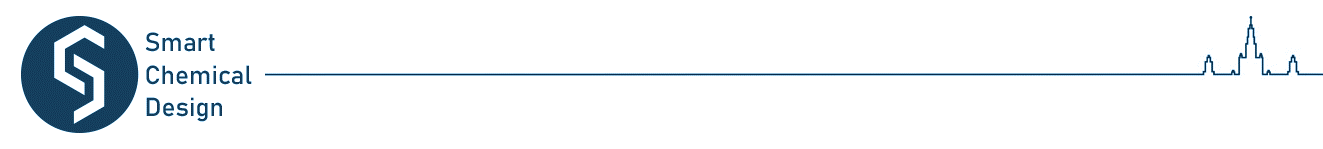

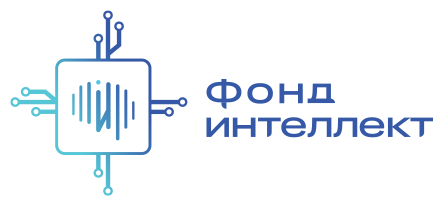

# Искусственный интеллект в химии  
## 16. Методы глобальной оптимизации

Поиск глобального и локальных минимумов на поверхности потенциальной энергии (ППЭ) является ключевой задачей для большинства исследований в области вычислительной химии. Имея набор возможных конформаций химических структур и соответствующие им энергии, можно судить об их химической активности, устанавливать механизмы реакций, описывать образование комплексов металл-лиганд, лиганд-белок и т. д.

**Цель данного практикума** - написать программу поиска глобального минимума на поверхности потенциальной энергии (ППЭ) молекул, используя метод Tree Parzen Estimator, входящий в состав библиотеки Hyperopt.  
Часть кода уже написана, необходимо дописать пропущенные участки кода и запустить процесс глобальной оптимизации

---

# Установка необходимых библиотек

In [ ]:
from typing import List

In [ ]:
# Установим Anaconda 
import sys
!{sys.executable} -m pip install condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
# Ждем завершения предыдущей ячейки

In [ ]:
!conda --version

conda 4.12.0


In [ ]:
# Установим библиотеку для вычисления полной внутренней энергии молекулы
# Название: XTB, сайт: https://github.com/grimme-lab/xtb-python
!conda install --yes xtb-python --channel conda-forge

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - xtb-python


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    xtb-python-20.2            |   py37h5e8e339_4         122 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         122 KB

The following packages will be UPDATED:

  xtb-python                            20.2-py37h5e8e339_3 --> 20.2-py37h5e8e339_4



xtb-python-20.2      | 122 KB    | : 100% 1.0/1 [00:00<00:00,  6.87it/s]                
Preparing transaction: \ done
Verifying transaction: / done
Executing transaction: \ done


In [ ]:
# Установим библиотеку для работы с представлениеми молекул
# Название: RDKit, сайт: https://www.rdkit.org/docs/
!conda install --yes rdkit --channel conda-forge

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [ ]:
# Установим библиотеку для проведения квантово-химических симуляций из Python
# Название: ASE, сайт: https://wiki.fysik.dtu.dk/ase/
!{sys.executable} -m pip install ase

In [ ]:
# Установим библиотеку с методом глобальной оптимизации
# Название: Hyperopt, сайт: http://hyperopt.github.io/hyperopt/#documentation
!{sys.executable} -m pip install hyperopt

In [ ]:
# Установим 3D рисовалку молекул
!{sys.executable} -m pip install py3Dmol
# И видео плеер для молекул
!{sys.executable} -m pip install nglview

In [ ]:
# пробуем все импортировать

from google.colab import output
output.enable_custom_widget_manager()

%matplotlib inline

import pickle
from typing import List

import matplotlib.pyplot as plt
import nglview
import numpy as np

from ase import Atoms
import ase.io
from ase.io.trajectory import TrajectoryWriter
from ase.visualize import view
from hyperopt import Trials, fmin, tpe, hp
from xtb.ase.calculator import XTB
from rdkit.Chem import AllChem
from rdkit import Chem

# Задание 1  
Написать функцию, получающую на вход строку SMILES и выдающую на выходе трехмерное представление молекулы в виде объекта RDKit  

*Подсказка: Для этого надо использовать библиотеку RDKit, ее документацию (ссылка выше), а также погуглить RDKit cookbook*

In [ ]:
def LoadMoleculeFromSMILES(SMILES: str) -> Chem.Mol:
    mol = Chem.MolFromSmiles(SMILES)
    mol = Chem.AddHs(mol)
    return mol

# Проверка задания 1

In [ ]:
import py3Dmol

def Draw3D_mol(m):
        mb = Chem.MolToMolBlock(m,confId=-1)
        p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

In [ ]:
smiles_test = "CCCCCCCC"
mol_test = LoadMoleculeFromSMILES(smiles_test) 
Draw3D_mol(mol_test)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---  
На этом занятии мы будем оптимизировать не координаты молекул (3*N координат, где N - число атомов), а лишь существенные степени свободы (те двугранные углы, которые образуют многообразие конформеров молекулы). Количество таких переменных значительно меньше, чем 3*N, что ускорит процесс оптимизации.

Функция для извлечения двугранных углов уже написана и представлена ниже:

In [ ]:
from operator import itemgetter

def FindValuableDihedralAngles(mol):
    # Извлекаем те двугранные углы, которые мы будем считать важными по SMILES шаблону
    pattern_tor = Chem.MolFromSmarts("[*]~[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]~[*]")
    torsion = list(mol.GetSubstructMatches(pattern_tor))

    # удаляем возможные дубликаты 
    # например, двугранный угол между атомами 1-2-3-4 и 4-3-2-1 = то же самое
    for_remove = []
    for x in reversed(range(len(torsion))):
        for y in reversed(range(x)):
            ix1, ix2 = itemgetter(1)(torsion[x]), itemgetter(2)(torsion[x])
            iy1, iy2 = itemgetter(1)(torsion[y]), itemgetter(2)(torsion[y])
            if (ix1 == iy1 and ix2 == iy2) or (ix1 == iy2 and ix2 == iy1):
                for_remove.append(y)
    clean_list = [v for i, v in enumerate(torsion) if i not in set(for_remove)]

    return clean_list

посмотрим, что возвращает эта функция:

In [ ]:
FindValuableDihedralAngles(mol_test)

[(10, 0, 1, 12),
 (12, 1, 2, 14),
 (14, 2, 3, 16),
 (16, 3, 4, 18),
 (18, 4, 5, 20),
 (20, 5, 6, 22),
 (22, 6, 7, 25)]

Получаем список двугранных углов  

Каждый элемент списка - индексы атомов, образующих каждый значимый двугранный угол

---

Далее, необходимо составить целевую функцию, которая будет использоваться для глобальной оптимизации.  
Эта функция принимает в качестве аргументов саму молекулу (Chem.Mol) и список значений ее двугранных углов.  
На выходе функция выдает значение полной внутренней энергии такой конформации.
Алгоритм оптимизации будет подбирать значения двугранных углов так, чтобы добиться минимального значения полной внутренней энергии такого конформера.

Функция расчета энергии будет уже написана. Осталось лишь имплементировать функцию подстановки значений двугранных углов в молекулу и приведение ее вида к определенному формату.

# Задание 2
Написать функцию, получающую на вход молекулу и значения двугранных углов, и выдающую на выходе трехмерное представление молекулы в виде объекта ASE (библиотека для квантово-химических вычислений)

In [ ]:
from rdkit.Chem import rdMolTransforms

In [ ]:
def CreateConformer(molecule: Chem.Mol, dihedral_angles: List[float], draw_result=False) -> Atoms:
    dihedral_indexes = FindValuableDihedralAngles(molecule)
    # задание 2.1: присвоить переменной список индексов,
    # образующих двугранные углы молекулы, поданной на вход функции
    maplist = mol_test.GetSubstructMatches(molecule)
    AllChem.EmbedMolecule(molecule)
    conf = molecule.GetConformer()

    for dihed, idx in zip(dihedral_angles, dihedral_indexes):
        a1 = idx[0]
        a2 = idx[1]
        a3 = idx[2]
        a4 = idx[3]
        rdMolTransforms.SetDihedralDeg(conf, a1,a2,a3,a4, dihed)
        
        # задание 2.2: применить значения двугранных углов к молекуле
        # подсказка - в RDKit есть функции, позволяющие применять 3D трансформации
        # к молекулам.

    coords = list()
    symbols = list()
    for i, atom in enumerate(list(molecule.GetAtoms())):
        coords.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y, conf.GetAtomPosition(i).z])
        symbols.append(atom.GetSymbol())

    # для проверки задания
        
    # преобразование RDKit объекта в два списка
    # первый список - набор символов элементов каждого атома
    # второй список - значения координат каждого атома (по 3 осям)
    # data = Chem.rdmolfiles.MolToXYZBlock(molecule).splitlines()[2:]
    # data = [x.split() for x in data]
    # symbols = [x[0] for x in data]
    # positions = [(float(x[1]), float(x[2]), float(x[3])) for x in data]
    
    # эти два списка необходимы для конвертирования молекулы в формат библиотеки ASE
    # отсюда вытекает задание 2.3: написать строку кода, которое позволит функции CreateConformer
    # вернуть объект типа ase.Atoms. В документации к библиотеке ASE есть описание, как это можно осуществить
    
    mol_atoms = Atoms(symbols=symbols, positions=coords)
    # if draw_result:
    #     view(mol_atoms, viewer='x3d')

    return mol_atoms
    

# Проверка задания 2

In [ ]:
from ase.visualize import view

In [ ]:
smiles_test = "CCCCCCCC"
mol_test = LoadMoleculeFromSMILES(smiles_test) 
atom_test = CreateConformer(mol_test, [0, 0, 0, 0, 0, 0, 0], True) # должна получиться кривая молекула, т.к. все углы равны 0 градусам
view(atom_test, viewer='x3d')

In [ ]:
atom_test = CreateConformer(mol_test, [120, 120, 120, -120, 120, 120, 120], True)
view(atom_test, viewer='x3d')
# Draw3D_mol(atom_test)

---  
Все вспомогательные функции имплементированы, осталось написать саму функцию, выполняющую глобальную оптимизацию!
Для этого будем использовать Tree Parzen Estimator из пакета Hyperopt

# Задание 3  
Написать функцию глобальной оптимизации. На вход подается молекула в представлении RDKit и максимальное число итераций. На выходе функция возвращает список двугранных углов, при которых достигается глобальный минимум. Кроме того, будет записан файл с результатами оптимизации. Это позволит далее визуализировать процесс оптимизации.

In [ ]:
from xtb.libxtb import VERBOSITY_MINIMAL
from xtb.interface import Calculator, Param
from ase.io.trajectory import Trajectory

In [ ]:
def GlobalOptimization(molecule, iterations_count=100):
    """
    :return: Список двугранных углов конформера в глобальном минимуме
    """
    dihedral_indexes = FindValuableDihedralAngles(molecule)
    number_of_params = len(dihedral_indexes)
    space = {}
    for i in range(1,len(FindValuableDihedralAngles(molecule))+1):
      key = i
      space[key] = hp.uniform(str(i), -180, 180)



    # Для оптимизации будем использовать функцию fmin из пакета Hyperopt (уже импортирована)
    # В качестве ее аргументов надо задать следующие переменные
    # - лосс-функция (GetEnergyByDihedrals), уже написана, см. далее
    # - пространство поиска, написана частично
    # - алгоритм оптимизации, а именно - Tree Parzen Estimator
    # - количество итераций
    # - объект для сохранения результатов оптимизации
    
    # Шаг 1: зададим лосс-функцию 
    def GetEnergyByDihedrals(dihedral_values_dict) -> float:
        """
        :return: Возвращает значение полной внутренней энергии конформера в глобальном минимуме
        """
        dihedral_values = dihedral_values_dict.keys()
        ase_mol = CreateConformer(molecule, dihedral_values)
        calc = Calculator(Param.GFN2xTB, ase_mol.get_atomic_numbers(), ase_mol.get_positions())
        calc.set_max_iterations(100)
        calc.set_verbosity(VERBOSITY_MINIMAL)
        try:
          res = calc.singlepoint()
          return res.get_energy()
        except: return np.inf

    trials = Trials()
    best = fmin(fn=GetEnergyByDihedrals, space=space, algo=tpe.suggest, max_evals=iterations_count, trials=trials)

    return best, trials

# Проверка задания 3

In [ ]:
result, trials = GlobalOptimization(mol_test, 100) # запускаем оптимизацию
print(result)

100%|██████████| 100/100 [00:41<00:00,  2.40it/s, best loss: -0.6510553522547768]
{'1': 97.1535607896808, '2': -178.51129307188435, '3': 168.39476682038568, '4': -49.09931214806362, '5': -66.9968509524683, '6': 25.03985122417666, '7': -105.50665388409405}


In [ ]:
def DrawGlobalOptimizationResults(trials):
    def get_min_loss(loss_list):
        losses = []
        for k in range(1, len(loss_list) + 1):
            losses.append(np.min(loss_list[:k]))
        return losses

    def get_mean_loss(loss_list):
        losses = []
        for k in range(1, len(loss_list) + 1):
            losses.append(np.mean(loss_list[:k]))
        return losses

    data = trials.losses()
    data = [n for n in data if np.isinf(n)==False]
    x = np.arange(len(data))
    plt.scatter(x, data, c='r')
    plt.plot(x, get_min_loss(data), color='b', label='Минимальное значение')
    plt.plot(x, get_mean_loss(data), color='g', label='Среднее значение')
    plt.legend()
    plt.xlabel("Номер итерации")
    plt.ylabel("Энергия")
    plt.show()
    
def DrawGlobalOptimizationMovie(molecule, trials):
    with TrajectoryWriter("glob_opt.traj", mode="w") as out:
        for trial in trials:
            dihedrals = [x[0] for x in trial["misc"]["vals"].values()]
            tmpmol = CreateConformer(molecule, dihedrals)
            out.write(tmpmol)

    traj = ase.io.read('glob_opt.traj', index=':')
    return view(traj, viewer="ngl")

Ниже продемонстрирована возможность визуализации глобальной оптимизации.  
Красные точки показывают значения энергии на каждой итерации.  
Зеленые и синие линии показывают средние и минимальные значения за всю историю оптимизации (до текущего шага).

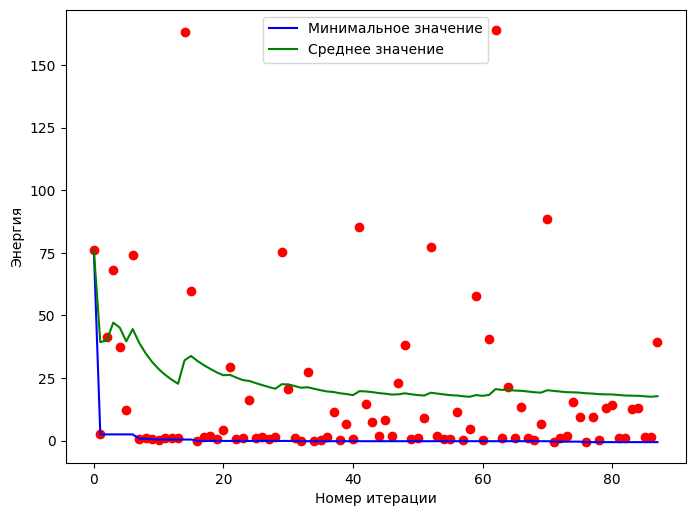

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
DrawGlobalOptimizationResults(trials)

Наконец, посмотрим на сгенерированные конформации.

In [ ]:
DrawGlobalOptimizationMovie(mol_test, trials)

Наконец, посмотрим на конформацию в глобальном минимуме

In [ ]:
best_dihedrals = [float(x) for x in result.values()]
view(CreateConformer(mol_test, best_dihedrals), viewer='x3d')

In [ ]:
best_dihedrals_mol = CreateConformer(mol_test, best_dihedrals)

In [ ]:
import pandas as pd
df_xyz = pd.DataFrame(best_dihedrals_mol.get_positions())
df_xyz.rename(columns = {0:'x', 1:'y', 2:'z'}, inplace = True)
df_xyz

,x,y,z
0,-4.170794,0.520374,-0.003498
1,-2.916524,0.013643,0.637201
2,-2.125254,-0.893161,-0.283254
3,-2.986732,-2.102532,-0.558279
4,-4.407844,-1.698079,-0.937714
5,-4.805353,-0.604378,0.004980
6,-5.058473,-1.075607,1.403056
7,-4.158700,-2.225981,1.726796
8,-4.149571,0.478736,-1.105172
9,-5.016561,-0.111320,0.394018


In [ ]:
df_xyz['atom'] = best_dihedrals_mol.get_chemical_symbols()
df_xyz = df_xyz[['atom', 'x', 'y', 'z']]
df_xyz.to_csv('best_mol.csv')